In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ML team project/Project 2/Neubauer Chamber Automation

!pip install import-ipynb

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12swurGjFVTSgi6fpziRcJ-tqsj6OoBgK/ML team project/Project 2/Neubauer Chamber Automation
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=0ec976a8928217a17cefd3d43aaa485bba3d08d6d7eb1a0581e98dbbd3a23814
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import numpy as np
import cv2
import imutils
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import import_ipynb
from UNetModel import UNet

import os

importing Jupyter notebook from UNetModel.ipynb


## Square detection

In [ ]:
def find_area(img, output_path, img_name , save = True):
    
    img_org=img.copy()                                                   #keep a copy of original image for second run                                   
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                         #convert image to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)                          #blur the image
    cleaned = cv2.fastNlMeansDenoising(blurred)                          #remove remaining noise
    
    #convert to binary using an adaptive threshold
    thresh = cv2.adaptiveThreshold(cleaned,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,0)    
    edges = cv2.Canny(thresh,100,200)                                    #define edges
    
    #get only strongly horizontal lines
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))             
    opening_horizontal = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_horizontal)
    closing_horizontal = cv2.morphologyEx(opening_horizontal, cv2.MORPH_CLOSE, kernel_horizontal, iterations=20)
    
    #get only strongly vertical lines
    kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1,15))
    opening_vertical = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_vertical)
    closing_vertical = cv2.morphologyEx(opening_vertical, cv2.MORPH_CLOSE, kernel_vertical, iterations=20)
    
    #combine horizontal & vertical lines and strengthen them
    combined=closing_horizontal|closing_vertical
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    closing = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=10)
    
    #detect squares
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area=[]
    coord_list=[]
    for c in contours:
        
        x,y,w,h = cv2.boundingRect(c)
        
        #keep only the countours that look like a square: w ~= h -> (np.abs((w-h))<=(0.1*w))
        #ignore squares created by the edges of the image: (x!=0)&((x+w)!=img.shape[1])&(y!=0)&((y+h)!=img.shape[0])
        #ignore small squares created by clustered cells: ((w*h)>(img.shape[0]*img.shape[1]*0.001))
        
        if (np.abs((w-h))<=(0.1*w))&(x!=0)&((x+w)!=img.shape[1])&(y!=0)&((y+h)!=img.shape[0])&((w*h)>(img.shape[0]*img.shape[1]*0.001)):
            
            cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 3)           #specify identified squares in green 
            area.append(w*h)
            coord_list.append([x,y,w,h]) 

    #group identified squares according to size
    df=pd.DataFrame({'area':area})
    df['coords']=coord_list
    df.sort_values(by='area', inplace=True, ignore_index=True)
    df['group']=0
    g=0
    
    for i in range(1, len(df)):
        if df['area'][i]>=df['area'][i-1]*1.9:              #min area in group is at least 1.9*max area of previous group
            df['group'][i]=g+1
            g=g+1
        else :
            df['group'][i]=g

    #specify reference squares       
    if g==0:                                                #if only a single type of square is detected include all
        keep=df
    #elif df[df['group']==g]['area'].mean()/df[df['group']==(g-1)]['area'].mean() > 4:   #if the biggest group's area is gratear than 4*next group's, keep the next group
     #   keep=df[df['group']==(g-1)]
    else :
        keep=df[df['group']==g]                             #otherwise default assumption is biggest squares are valid 
        
        
    #if number of valid reference squares detected is 0 or 1, rerun the sequence with increased sensitivity
    if len(keep)<=1: 
        
        img=img_org
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.bilateralFilter(gray,15,75,75)           #instead of Gaussian blur, bilateral blurring
        cleaned = cv2.fastNlMeansDenoising(blurred)
        thresh = cv2.adaptiveThreshold(cleaned,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,0)
        edges = cv2.Canny(thresh,100,200) 
        
        #get only horizontal lines
        kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (11,1))            #detect smaller sized lines
        opening_horizontal = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_horizontal)
        closing_horizontal = cv2.morphologyEx(opening_horizontal, cv2.MORPH_CLOSE, kernel_horizontal, iterations=100)   #increased iterations to concretize weak lines
        
        #get only vertical lines
        kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1,11))
        opening_vertical = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel_vertical)      #detect smaller sized lines
        closing_vertical = cv2.morphologyEx(opening_vertical, cv2.MORPH_CLOSE, kernel_vertical, iterations=100)         #increased iterations to concretize weak lines
        
        #combine
        combined=closing_horizontal|closing_vertical
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        closing = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=10)
        
        #detects squares
        contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        area=[]
        coord_list=[]
    
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            
            #keep only the countours that look like a square: w ~= h -> (np.abs((w-h))<=(0.1*w))
            #ignore squares created by the edges of the image: (x!=0)&((x+w)!=img.shape[1])&(y!=0)&((y+h)!=img.shape[0])
            #ignore small squares created by clustered cells: ((w*h)>(img.shape[0]*img.shape[1]*0.001))
        
            if (np.abs((w-h))<=(0.1*w))&(x!=0)&((x+w)!=img.shape[1])&(y!=0)&((y+h)!=img.shape[0])&((w*h)>(img.shape[0]*img.shape[1]*0.001)):
                cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 3)
                area.append(w*h)
                coord_list.append([x,y,w,h])
        
        #group identified squares according to size
        df=pd.DataFrame({'area':area})
        df['coords']=coord_list
        df.sort_values(by='area', inplace=True, ignore_index=True)
        df['group']=0
        g=0
        
        for i in range(1, len(df)):
            if df['area'][i]>=df['area'][i-1]*1.9:                  #min area in group is at least 1.9*max area of previous group
                df['group'][i]=g+1
                g=g+1
            else :
                df['group'][i]=g
        
        #specify reference squares
        if g==0:
            keep=df                                                 #if only a single type of square is detected include all
        #elif df[df['group']==g]['area'].mean()/df[df['group']==(g-1)]['area'].mean() > 4:     #if the smallest group's area is smaller than 0.25*next group's, they are cells, ignore and move to next group
         #   keep=df[df['group']==(g-1)]
        else :
            keep=df[df['group']==g]                                #otherwise default assumption is smallest squares are valid 
        
    
    valid_area=list(keep['area'])
    valid_coord=list(keep['coords'])

    #show valid squares
    for c in valid_coord:
        cv2.rectangle(img, (c[0], c[1]), (c[0] + c[2], c[1] + c[3]), (0,0,255), 3)  #draw red squares to specify the reference squares
    
    if save:
        cv2.imwrite(output_path+str(img_name)+'valid_detected.png',img)   #save image to control
    
    #calculate number of reference squares fitting into image
    ref_square_area=np.mean(valid_area)                         # average the reference squares' areas
    total_area=img.shape[0]*img.shape[1]                        # find the total area of the image
    num_squares_fit=total_area/ref_square_area                  # find how many reference squares would fit into total image
    
    return np.round(num_squares_fit,2)

## Cell Segmentation and Counting

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import Resize

import matplotlib.pyplot as plt

In [ ]:
def count_cells(image, mask, thresh=1, plot=True):
    contours,hierarchy = cv2.findContours(mask, 1, 2)

    out = image.copy()
    coords = []
    for cnt in contours:
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        if radius < thresh:
            continue
        center = (int(x),int(y))
        radius = int(radius)
        coords.append([int(x), int(y), radius])
        cv2.circle(out,center,radius,(0,255,0),2)
   
    return out, np.array(coords)

In [ ]:
state_dict = torch.load('models/unet2_bilinear_CombinedLoss.pt', map_location=torch.device('cpu'))['model_state_dict']
model = UNet(3,2)
model.load_state_dict(state_dict)

<All keys matched successfully>

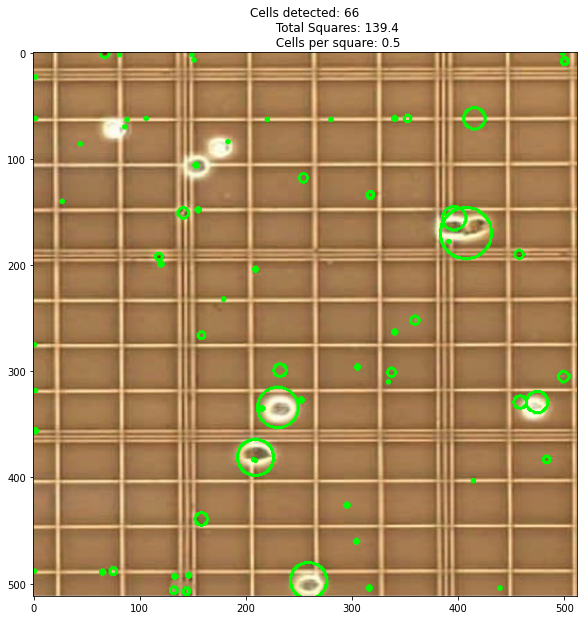

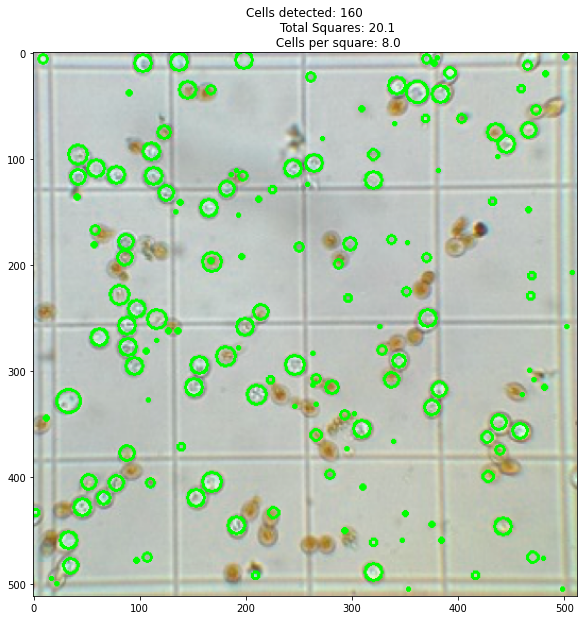

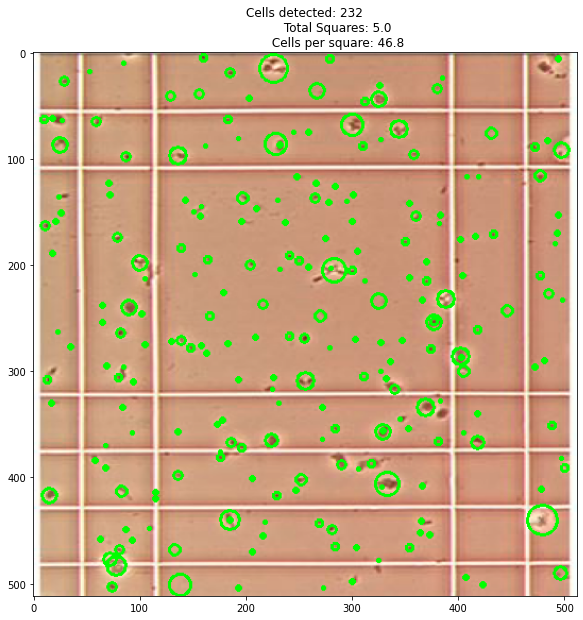

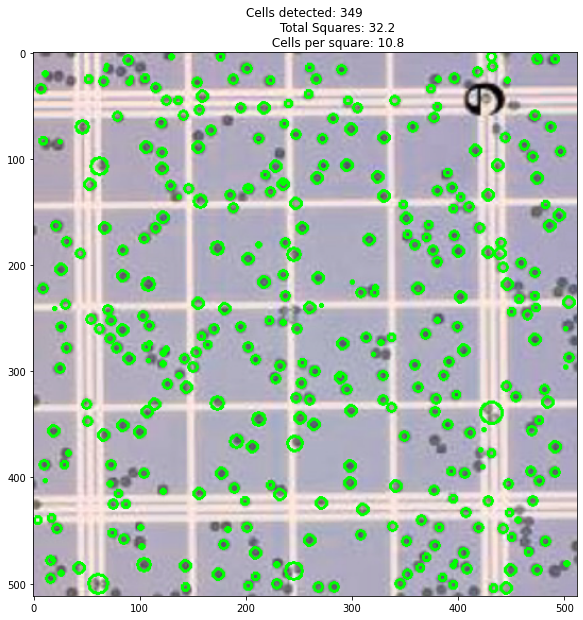

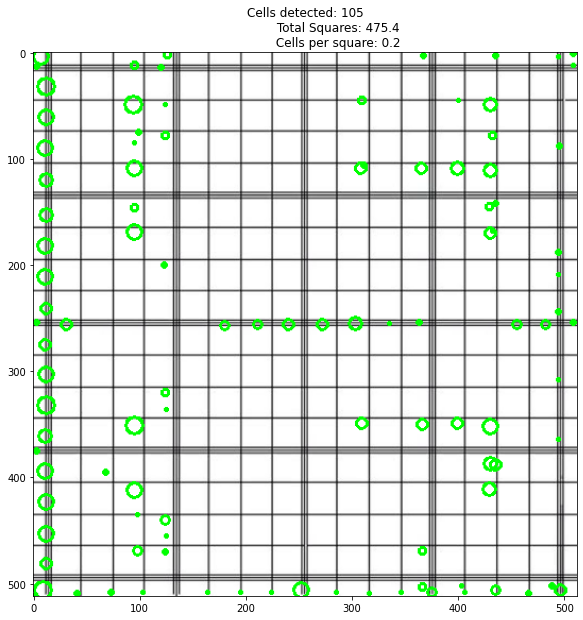

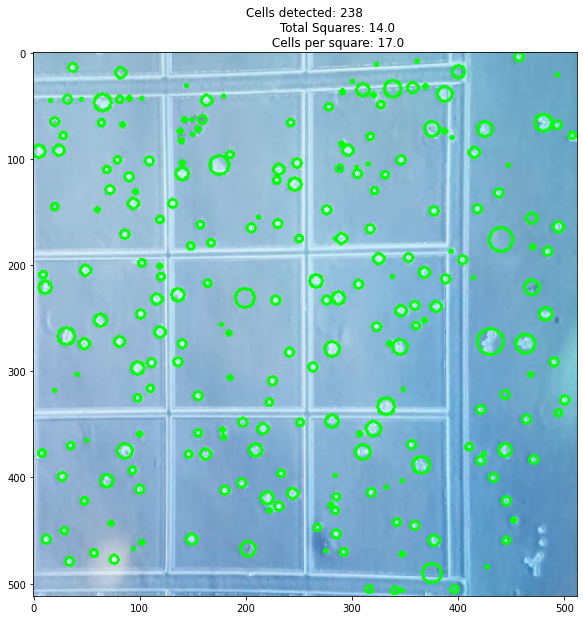

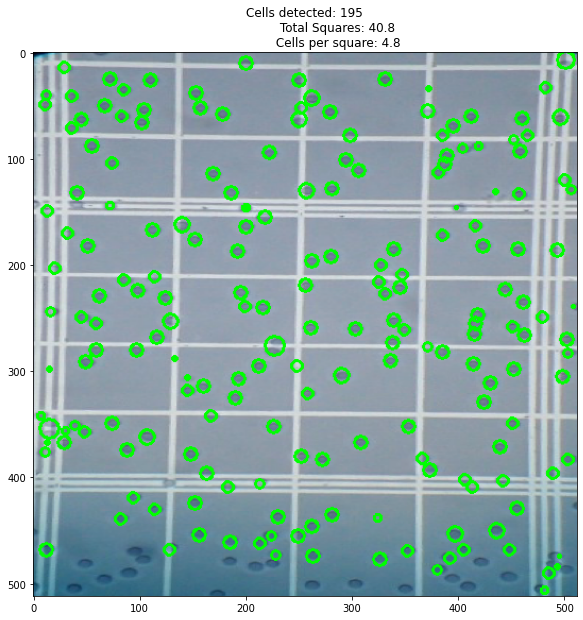

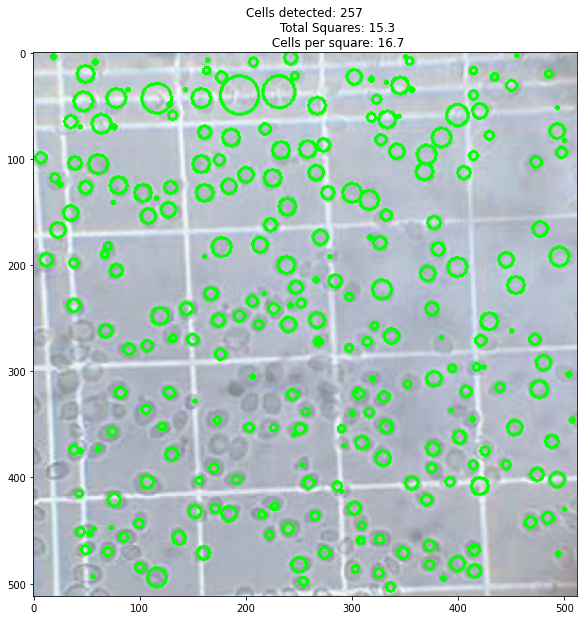

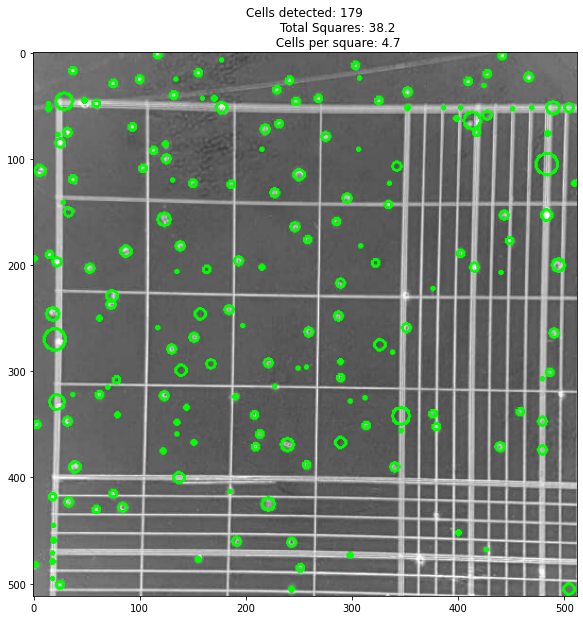

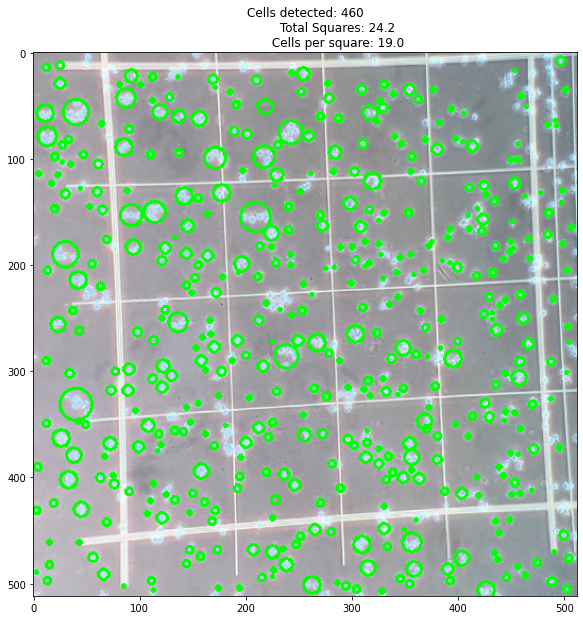

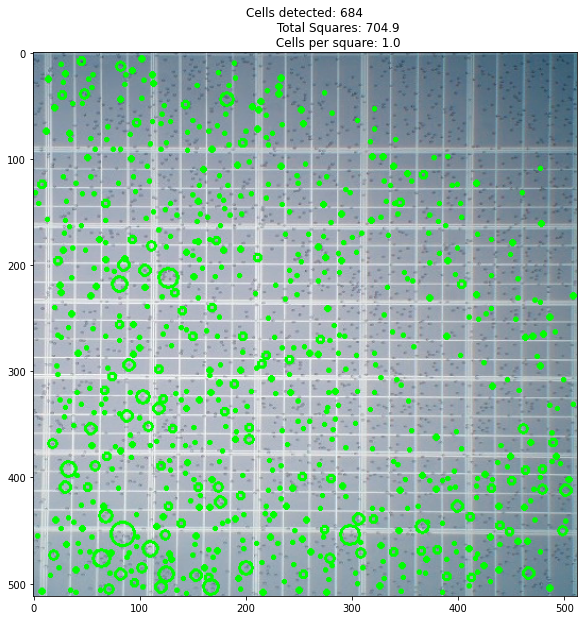

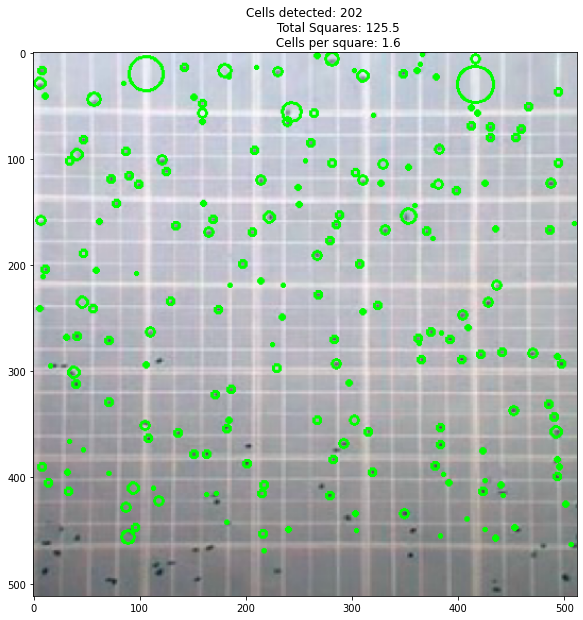

In [ ]:
N = 6
#Get data
DATA_PATH = 'Data Set/Square Detection/Cropped-augmented-norotation/'
image_names = os.listdir(DATA_PATH)
predicted_masks = []
for file in image_names[N:3*N]:
    #Load image. Here we keep an original just for simplicity (cv2 needs uint8)
    original_im = cv2.imread(DATA_PATH+file)
    im = original_im/255.0
    im = torch.from_numpy(im.astype('float32')).transpose(2,0).unsqueeze(0)
    im = Resize((512,512))(im)

    #Get predictions
    mask = model(im).detach().argmax(dim=1)
    mask = (mask*255).numpy().astype('uint8')[0]

    #Get image to correct shape
    im = im[0].transpose(2,0).transpose(1,0).numpy()
    im = (im*255).astype('uint8')

    #Annotate and get cell count
    annotated_im, coords = count_cells(im, mask)
    cell_count = len(coords)
    
    #Get square count
    square_count = find_area(original_im, '', '')
    concentration = cell_count/square_count
    
    #Plot
    plt.figure(figsize=(10,10))
    plt.imshow(annotated_im)
    plt.title(f'Cells detected: {cell_count}\nTotal Squares: {square_count:.1f}\nCells per square: {concentration:.1f}')
    
